In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import tqdm
import datetime
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

%load_ext tensorboard

In [2]:
path = './dataset/train_images/' # Path to directory which contains classes
model = "VGG16"
folder_name = "{0}_{1}".format(model, datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S"))
checkpoint_folder = './checkpoints/{0}/'.format(folder_name)
tensorboard_folder = "tensorboard/fit/{0}/".format(model)

try:
    os.mkdir(tensorboard_folder, 0o755)
except:
    pass
os.mkdir(checkpoint_folder, 0o755)

log_dir = tensorboard_folder + datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_filepath = checkpoint_folder + 'epoch-{epoch:02d}-val_loss-{val_loss:.2f}.tf'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                         monitor='val_loss', 
                                                         save_weights_only=True,
                                                         mode='min')

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                       min_delta=1e-4,
                                                       patience=15,
                                                       verbose=1,
                                                       mode="min")

classes = os.listdir(path) # List of all classes
print('Total number of categories: {0}'.format(len(classes)))

Total number of categories: 9


Total number of images in dataset: 10384


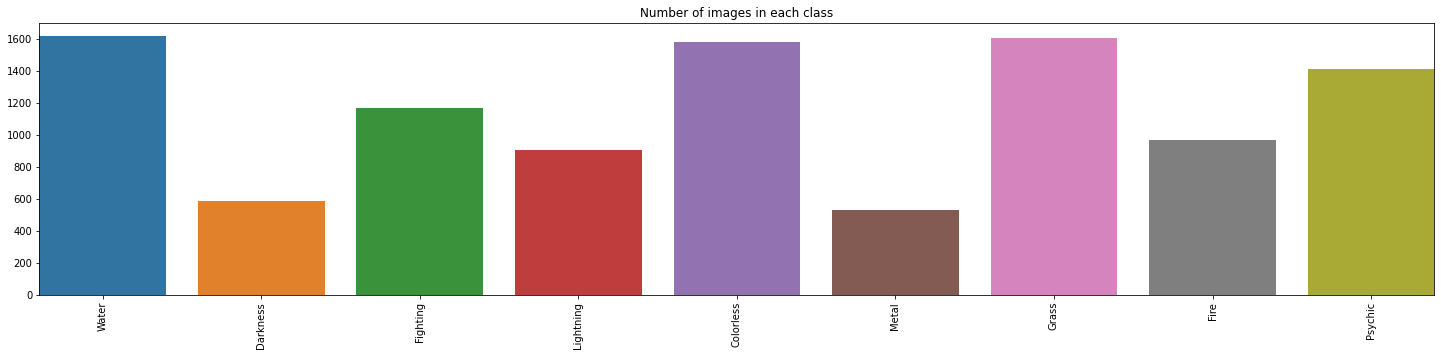

In [3]:
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))

num_images = sum(list(counts.values()))
print('Total number of images in dataset: {0}'.format(num_images))

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.barplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    dtype='float32',
    horizontal_flip = True,
    #vertical_flip = True,
    rotation_range = 30,
    zoom_range = 0.2,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.2
)

train_generator = train_datagen.flow_from_directory(
    'dataset/train_images',
    batch_size=8,
    target_size=(300,300),
    class_mode='sparse',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'dataset/train_images',
    batch_size=8,
    target_size=(300,300),
    class_mode='sparse',
    subset="validation"
)

Found 8311 images belonging to 9 classes.
Found 2073 images belonging to 9 classes.


In [5]:
train_generator.class_indices

{'Colorless': 0,
 'Darkness': 1,
 'Fighting': 2,
 'Fire': 3,
 'Grass': 4,
 'Lightning': 5,
 'Metal': 6,
 'Psychic': 7,
 'Water': 8}

In [6]:
balance_weights = {}

max_count = max(counts.values())
for k, v in counts.items():
    balance_weights[train_generator.class_indices[k]] = max_count/v

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
model = tf.keras.applications.VGG16(input_shape=(300,300,3), classes=9, weights=None, include_top=True)

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [11]:
history = model.fit(train_generator, epochs=250, verbose=True, 
                    callbacks=[tensorboard_callback, checkpoint_callback, early_stop_callback],
                    validation_data=validation_generator, class_weight=balance_weights)

Epoch 1/250
   1/1039 [..............................] - ETA: 0s - loss: 2.9874 - accuracy: 0.0000e+00WARNING:tensorflow:From /home/lucas/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1039/1039 [==============================] - 320s 308ms/step - loss: 3.1108 - accuracy: 0.1171 - val_loss: 2.1971 - val_accuracy: 0.0564
Epoch 2/250
1039/1039 [==============================] - 342s 329ms/step - loss: 3.0842 - accuracy: 0.0922 - val_loss: 2.1976 - val_accuracy: 0.0564
Epoch 3/250
1039/1039 [==============================] - 363s 349ms/step - loss: 3.0842 - accuracy: 0.0673 - val_loss: 2.1966 - val_accuracy: 0.1124
Epoch 4/250
1039/1039 [==============================] - 314s 303ms/step - loss: 3.0843 - accuracy: 0.0945 - val_loss: 2.1966 - val_accuracy: 0.1124
Epoch 5/250
1039/1039 [=====

In [12]:
best_epoch = np.argmin(history.history['val_loss']) + 1
best_loss = np.min(history.history['val_loss'])
model.load_weights(checkpoint_folder+'epoch-{0:02d}-val_loss-{1:.2f}.tf'.format(best_epoch, best_loss))

In [13]:
scores = model.evaluate(x=validation_generator, verbose=1)

260/260 [==============================] - 33s 128ms/step - loss: 2.1959 - accuracy: 0.1548


Grass 11.305104196071625%


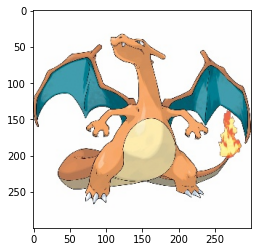

In [14]:
img = np.array(cv2.imread("./dataset/test_images/6.jpg", cv2.IMREAD_COLOR))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img/256.0

plt.imshow(img)

res = model.predict(np.array([img]))[0]
print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(np.argmax(res))], str(np.max(res)*100)+"%")

In [15]:
Y_pred = model.predict(validation_generator, 2084 // 8+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = ['Colorless', 'Darkness','Fighting','Fire','Grass','Lightning','Metal','Psychic','Water']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   Colorless       0.00      0.00      0.00       315
    Darkness       0.00      0.00      0.00       117
    Fighting       0.00      0.00      0.00       233
        Fire       0.00      0.00      0.00       194
       Grass       0.15      1.00      0.27       321
   Lightning       0.00      0.00      0.00       181
       Metal       0.00      0.00      0.00       106
     Psychic       0.00      0.00      0.00       283
       Water       0.00      0.00      0.00       323

    accuracy                           0.15      2073
   macro avg       0.02      0.11      0.03      2073
weighted avg       0.02      0.15      0.04      2073



/home/lucas/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix


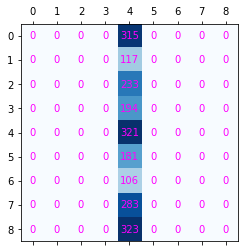

In [16]:
print('Confusion Matrix')
c_matrix = confusion_matrix(validation_generator.classes, y_pred)

fig, ax = plt.subplots()
ax.matshow(c_matrix,  cmap=plt.cm.Blues)
for i in range(9):
    for j in range(9):
        c = c_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center', fontdict={'color': 'magenta'})